# 고급 RAG 기법 (Advanced RAG Techniques)

이번 노트북은 **07-1.rag_evaluation.ipynb**에서 이어지는 내용으로, **고급 RAG 기법**을 학습하고 동일한 테스트 데이터로 평가합니다.

## 학습 목표
기본 RAG(07-1)를 넘어서 실무에서 활용할 수 있는 고급 기법들을 익히고, **동일한 평가 프레임워크**로 성능을 비교합니다.

## 오늘 배울 내용

### Ingest (데이터 수집 및 전처리) 고급 기법
1. **LangChain 없이 순수 Python으로 구현** - 최대한의 유연성을 위해 프레임워크 의존성 제거
2. **LLM을 활용한 지능형 청킹** - 단순 문자 수 기반이 아닌, LLM이 문맥을 이해하여 의미 있는 단위로 분할
3. **문서 전처리 (Document Pre-processing)** - LLM이 검색에 유리하도록 청크를 재작성

### Retrieval (검색) 고급 기법
4. **Reranking** - 검색 결과를 LLM이 재정렬하여 정확도 향상
5. **Query Rewriting** - 사용자 질문을 검색에 최적화된 형태로 변환

### Evaluation (평가)
6. **07-1과 동일한 지표로 평가** - MRR, nDCG, Precision@K, Recall@K, LLM-as-a-Judge

## 07-1 기본 RAG vs 07-4 고급 RAG

| 구분 | 07-1 기본 RAG | 07-4 고급 RAG |
|------|-------------|-------------|
| 프레임워크 | LangChain | 순수 Python |
| 청킹 | RecursiveCharacterTextSplitter (고정 크기) | LLM 기반 지능형 청킹 |
| 검색 | 단순 벡터 유사도 | 벡터 유사도 + Reranking |
| 쿼리 | 원본 질문 그대로 | Query Rewriting 적용 |
| Knowledge Base | 동일 (`00_test_data/knowledge_base`) | 동일 |
| 테스트 데이터 | 동일 (`tests.jsonl`) | 동일 |
| 평가 지표 | MRR, nDCG, Precision, Recall, LLM Judge | 동일 |

In [1]:
import json
import math
from pathlib import Path
from collections import Counter
from openai import OpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from chromadb import PersistentClient
from tqdm import tqdm
from litellm import completion
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.graph_objects as go


load_dotenv(override=True)

MODEL = "gpt-4.1-nano"

DB_NAME = "advanced_vector_db"
collection_name = "docs"
embedding_model = "text-embedding-3-large"
KNOWLEDGE_BASE_PATH = Path("../00_test_data/knowledge_base")
TEST_FILE = str(Path("../00_test_data/test_dataset/tests.jsonl"))
AVERAGE_CHUNK_SIZE = 500
RETRIEVAL_K = 10

# matplotlib 한글 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

openai = OpenAI()

print(f"모델: {MODEL}")
print(f"Knowledge Base: {KNOWLEDGE_BASE_PATH}")
print(f"벡터DB: {DB_NAME}")
print(f"테스트 파일: {TEST_FILE}")

모델: gpt-4.1-nano
Knowledge Base: ../00_test_data/knowledge_base
벡터DB: advanced_vector_db
테스트 파일: ../00_test_data/test_dataset/tests.jsonl


## 테스트 데이터 로드

07-1에서 사용한 것과 **동일한 테스트 데이터**(tests.jsonl)를 사용합니다.
고급 RAG 기법 적용 후 동일한 평가 지표로 성능을 비교할 수 있습니다.

In [2]:
class TestQuestion(BaseModel):
    """RAG 평가용 테스트 질문 모델 (07-1과 동일)"""
    question: str = Field(description="RAG 시스템에 던질 질문")
    keywords: list[str] = Field(description="검색 결과에 포함되어야 하는 키워드들")
    reference_answer: str = Field(description="정답 (Ground Truth)")
    category: str = Field(description="질문 카테고리")
    source_docs: list[str] = Field(default_factory=list, description="정답이 포함된 원본 문서 경로들")


def normalize_source(source_path: str) -> str:
    """청크 metadata의 source 경로를 정규화하여 knowledge_base/ 이하 상대 경로로 변환"""
    if "knowledge_base/" in source_path:
        return source_path.split("knowledge_base/")[-1]
    return source_path


def load_tests(filepath: str = TEST_FILE) -> list[TestQuestion]:
    """JSONL 파일에서 테스트 케이스 로드"""
    tests = []
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            data = json.loads(line)
            tests.append(TestQuestion(**data))
    return tests


tests = load_tests()
print(f"총 {len(tests)}개의 테스트 케이스 로드됨\n")

# 카테고리별 분포
category_counts = Counter(t.category for t in tests)
print("카테고리별 분포:")
for cat, count in sorted(category_counts.items()):
    print(f"  {cat}: {count}개")

# 첫 번째 테스트 확인
t = tests[0]
print(f"\n[테스트 예시]")
print(f"  Question    : {t.question}")
print(f"  Keywords    : {t.keywords}")
print(f"  Answer      : {t.reference_answer}")
print(f"  Source Docs : {t.source_docs}")

총 146개의 테스트 케이스 로드됨

카테고리별 분포:
  comparative: 19개
  direct_fact: 49개
  holistic: 10개
  numerical: 20개
  relationship: 15개
  spanning: 14개
  temporal: 19개

[테스트 예시]
  Question    : 하늘여행사는 언제 설립되었나요?
  Keywords    : ['2008년', '3월 15일']
  Answer      : 하늘여행사는 2008년 3월 15일에 설립되었습니다.
  Source Docs : ['company/overview.md', 'company/history.md', 'employees/kim_haneul.md']


In [ ]:
# LangChain의 Document 클래스와 비슷하게 만든 구조 

class Result(BaseModel):
    page_content: str
    metadata: dict

### Structured Output이란?

LLM의 응답을 **정해진 JSON 스키마**에 맞춰 받는 기능입니다.

**일반 LLM 응답 (자유 텍스트):**
```
이 문서의 첫 번째 청크는 회사 개요이고, 두 번째 청크는...
```
→ 파싱이 어렵고, 형식이 매번 달라질 수 있음

**Structured Output (JSON 스키마 강제):**
```json
{
  "chunks": [
    {
      "headline": "회사 개요",
      "summary": "하늘여행사는 2008년에 설립된...",
      "original_text": "# 회사 개요\n## 주식회사 하늘여행사..."
    }
  ]
}
```
→ Pydantic 모델로 자동 파싱 가능, 안정적인 출력

**사용 방법:**

1. **Pydantic 모델 정의** — 원하는 출력 구조를 Python 클래스로 선언
2. **`response_format=모델`** — LLM 호출 시 모델을 지정하면 해당 스키마의 JSON으로 응답
3. **`model_validate_json()`** — 응답 JSON을 Pydantic 객체로 변환

```python
# 1. 스키마 정의
class Chunk(BaseModel):
    headline: str = Field(description="제목")
    summary: str = Field(description="요약")

class Chunks(BaseModel):
    chunks: list[Chunk]

# 2. LLM 호출 시 response_format 지정
response = completion(model=MODEL, messages=messages, response_format=Chunks)

# 3. JSON → Pydantic 객체로 파싱
result = Chunks.model_validate_json(response.choices[0].message.content)
```

**핵심 포인트:**
- `Field(description=...)`의 설명이 LLM에게 각 필드를 어떻게 채울지 알려주는 역할
- description이 상세할수록 LLM의 출력 품질이 높아짐
- OpenAI, Anthropic 등 주요 LLM 프로바이더가 지원

In [4]:
# Chunk를 표현하는 Pydantic 모델
# LLM의 Structured Output을 위해 Field description을 상세히 작성

class Chunk(BaseModel):
    headline: str = Field(description="A brief heading for this chunk, typically a few words, that is most likely to be surfaced in a query")
    summary: str = Field(description="A few sentences summarizing the content of this chunk to answer common questions")
    original_text: str = Field(description="The original text of this chunk from the provided document, exactly as is, not changed in any way")

    def as_result(self, document):
        metadata = {"source": document["source"], "type": document["type"]}
        return Result(page_content=self.headline + "\n\n" + self.summary + "\n\n" + self.original_text,metadata=metadata)


class Chunks(BaseModel):
    chunks: list[Chunk]

## 데이터 수집 파이프라인 3단계

RAG 시스템의 데이터 수집(Ingest) 과정은 다음 3단계로 구성됩니다:

1. **문서 로드 (Fetch)** - Knowledge Base에서 문서들을 가져옵니다 (LangChain의 DirectoryLoader와 유사)
2. **LLM 기반 청킹** - LLM을 호출하여 문서를 의미 있는 Chunk로 분할합니다
3. **벡터 저장** - 생성된 Chunk들을 ChromaDB에 저장합니다

이것이 전부입니다! 간단하죠?

### Step 1: 문서 로드하기

아래 함수는 LangChain의 `DirectoryLoader`를 순수 Python으로 구현한 것입니다.
폴더 구조에서 문서 타입을 추출하고, 모든 마크다운 파일을 읽어옵니다.

In [5]:
def fetch_documents():
    """LangChain DirectoryLoader의 순수 Python 구현"""

    documents = []

    for folder in KNOWLEDGE_BASE_PATH.iterdir():
        doc_type = folder.name
        for file in folder.rglob("*.md"):
            with open(file, "r", encoding="utf-8") as f:
                documents.append({"type": doc_type, "source": file.as_posix(), "text": f.read()})

    print(f"Loaded {len(documents)} documents")
    return documents

In [6]:
documents = fetch_documents()

Loaded 18 documents


In [7]:
# 첫 번째 문서의 구조 확인
print(f"문서 개수: {len(documents)}")
print(f"\n첫 번째 문서 구조:")
print(f"  - type: {documents[0]['type']}")
print(f"  - source: {documents[0]['source']}")
print(f"  - text 길이: {len(documents[0]['text'])} 글자")
print(f"  - text 미리보기: {documents[0]['text'][:200]}...")

문서 개수: 18

첫 번째 문서 구조:
  - type: products
  - source: ../00_test_data/knowledge_base/products/vietnam_danang.md
  - text 길이: 3999 글자
  - text 미리보기: # 베트남 다낭 4박5일

## 상품 개요

- **상품명**: 베트남 다낭-호이안 4박5일
- **상품코드**: VN-DNG-4N5D
- **여행 기간**: 4박 5일
- **출발지**: 인천국제공항
- **도착지**: 다낭 국제공항
- **이동 수단**: 국제선 항공 + 전용 차량
- **가이드**: 한국어 가이드 전 일정 동행
- **최소 출발 인원*...


### 문서(Document) 구조 이해하기

`fetch_documents()` 함수가 반환하는 `documents`는 딕셔너리 리스트입니다.

**각 문서의 구조:**

```python
{
    "type": str,    # 문서 타입 (폴더 이름에서 추출)
    "source": str,  # 파일 경로 (출처 추적용)
    "text": str     # 파일 전체 내용
}
```

**Knowledge Base 폴더 구조 (07-1과 동일):**

```
00_test_data/knowledge_base/
├── company/            # type = "company"
│   ├── overview.md
│   └── history.md
├── employees/          # type = "employees"
│   ├── kim_haneul.md
│   ├── park_minsoo.md
│   ├── song_minji.md
│   ├── kang_jihoon.md
│   └── kwon_nara.md
├── products/           # type = "products"
│   ├── jeju_healing.md
│   ├── japan_osaka.md
│   ├── vietnam_danang.md
│   └── maldives_honeymoon.md
├── contracts/          # type = "contracts"
│   ├── samsung_incentive.md
│   └── hyundai_mice.md
├── policies/           # type = "policies"
│   ├── booking.md
│   ├── cancellation.md
│   └── insurance.md
└── faq/                # type = "faq"
    ├── general.md
    └── product.md
```

**왜 이 구조인가?**

| 필드 | 용도 |
|-----|------|
| `type` | 문서 분류, 필터링 검색, 시각화 색상 구분에 활용 |
| `source` | 답변 시 출처 표시, 디버깅, 추적에 활용 |
| `text` | LLM 청킹의 입력 데이터 |

이 메타데이터는 나중에 ChromaDB에 저장되어 검색 결과와 함께 반환됩니다.

### Step 2: LLM 기반 지능형 청킹

이제 핵심인 **LLM 기반 청킹**을 구현합니다.

기존 방식 vs LLM 기반 방식:

| 기존 방식 | LLM 기반 방식 |
|----------|--------------|
| 고정 문자 수로 분할 | 의미 단위로 분할 |
| 문맥 무시 | 문맥 이해 |
| 단순 오버랩 | 지능적 오버랩 |
| 원본 텍스트만 저장 | headline + summary + 원본 저장 |

LLM에게 다음을 요청합니다:
- **headline**: 검색에 유리한 짧은 제목
- **summary**: 핵심 내용 요약
- **original_text**: 원본 텍스트 (변경 없이)

이렇게 하면 검색 시 headline과 summary가 매칭 확률을 높여줍니다.

In [8]:
def make_prompt(document):
    how_many = (len(document["text"]) // AVERAGE_CHUNK_SIZE) + 1
    return f"""
You take a document and you split the document into overlapping chunks for a KnowledgeBase.

The document is from the shared drive of a travel company called 하늘여행사 (Sky Travel).
The document is of type: {document["type"]}
The document has been retrieved from: {document["source"]}

A chatbot will use these chunks to answer questions about the company.
You should divide up the document as you see fit, being sure that the entire document is returned in the chunks - don't leave anything out.
This document should probably be split into {how_many} chunks, but you can have more or less as appropriate.
There should be overlap between the chunks as appropriate; typically about 25% overlap or about 50 words, so you have the same text in multiple chunks for best retrieval results.

For each chunk, you should provide a headline, a summary, and the original text of the chunk.
Together your chunks should represent the entire document with overlap.

Here is the document:

{document["text"]}

Respond with the chunks.
"""

In [9]:
print(make_prompt(documents[0]))


You take a document and you split the document into overlapping chunks for a KnowledgeBase.

The document is from the shared drive of a travel company called 하늘여행사 (Sky Travel).
The document is of type: products
The document has been retrieved from: ../00_test_data/knowledge_base/products/vietnam_danang.md

A chatbot will use these chunks to answer questions about the company.
You should divide up the document as you see fit, being sure that the entire document is returned in the chunks - don't leave anything out.
This document should probably be split into 8 chunks, but you can have more or less as appropriate.
There should be overlap between the chunks as appropriate; typically about 25% overlap or about 50 words, so you have the same text in multiple chunks for best retrieval results.

For each chunk, you should provide a headline, a summary, and the original text of the chunk.
Together your chunks should represent the entire document with overlap.

Here is the document:

# 베트남 다낭 

In [10]:
def make_messages(document):
    return [
        {"role": "user", "content": make_prompt(document)},
    ]

In [11]:
make_messages(documents[0])

[{'role': 'user',
  'content': "\nYou take a document and you split the document into overlapping chunks for a KnowledgeBase.\n\nThe document is from the shared drive of a travel company called 하늘여행사 (Sky Travel).\nThe document is of type: products\nThe document has been retrieved from: ../00_test_data/knowledge_base/products/vietnam_danang.md\n\nA chatbot will use these chunks to answer questions about the company.\nYou should divide up the document as you see fit, being sure that the entire document is returned in the chunks - don't leave anything out.\nThis document should probably be split into 8 chunks, but you can have more or less as appropriate.\nThere should be overlap between the chunks as appropriate; typically about 25% overlap or about 50 words, so you have the same text in multiple chunks for best retrieval results.\n\nFor each chunk, you should provide a headline, a summary, and the original text of the chunk.\nTogether your chunks should represent the entire document wi

### process_document 함수 상세 설명

`process_document`는 이 노트북의 **핵심 함수**입니다. 단일 문서를 LLM에게 전달하여 지능형 청킹을 수행합니다.

**함수 동작 흐름:**

```
문서 (Document)
    ↓
make_messages() - 프롬프트 생성
    ↓
LLM API 호출 (litellm.completion)
    ↓
Structured Output (JSON) 파싱
    ↓
Chunk 객체 리스트로 변환
    ↓
Result 객체 리스트 반환
```

**핵심 포인트:**

1. **Structured Output 활용**
   - `response_format=Chunks`를 지정하여 LLM이 정해진 JSON 스키마로 응답
   - Pydantic 모델로 자동 검증 및 파싱

2. **LLM이 결정하는 것들**
   - 청크 분할 위치 (의미 단위로)
   - 각 청크의 headline (검색용 제목)
   - 각 청크의 summary (핵심 요약)
   - 오버랩 범위 (문맥 보존을 위해)

3. **왜 이 방식이 효과적인가?**
   - 단순 문자 수 분할은 문장 중간에서 끊길 수 있음
   - LLM은 문단, 주제, 논리적 구분을 이해함
   - headline과 summary가 검색 매칭률을 높임

In [12]:
def process_document(document):
    """
    단일 문서를 LLM 기반 지능형 청킹으로 처리하는 핵심 함수
    
    Args:
        document: dict - {"type": str, "source": str, "text": str} 형태의 문서
        
    Returns:
        list[Result] - headline, summary, original_text가 결합된 Result 객체 리스트
        
    처리 과정:
        1. make_messages()로 LLM 프롬프트 생성
        2. litellm.completion()으로 LLM 호출 (Structured Output 사용)
        3. Pydantic으로 JSON 응답을 Chunks 모델로 파싱
        4. 각 Chunk를 Result 객체로 변환하여 반환
    """
    # 1. 문서를 LLM 메시지 형식으로 변환
    messages = make_messages(document)
    
    # 2. LLM 호출 - response_format으로 Pydantic 모델을 지정하면
    #    LLM이 해당 스키마에 맞는 JSON으로 응답함 (Structured Output)
    response = completion(model=MODEL, messages=messages, response_format=Chunks)
    
    # 3. LLM 응답에서 JSON 문자열 추출
    reply = response.choices[0].message.content
    
    # 4. JSON을 Pydantic 모델로 파싱하여 Chunk 리스트 획득
    doc_as_chunks = Chunks.model_validate_json(reply).chunks
    
    # 5. 각 Chunk를 Result 형태로 변환 (headline + summary + original_text 결합)
    return [chunk.as_result(document) for chunk in doc_as_chunks]

In [13]:
process_document(documents[0])

[Result(page_content='상품 개요\n\n이 상품은 베트남 다낭과 호이안을 4박 5일 동안 여행하는 패키지 상품으로, 출발지와 도착지, 여행 기간, 이동 수단, 가이드 정보, 최소 인원 등을 포함합니다.\n\n# 베트남 다낭 4박5일\n\n## 상품 개요\n\n- **상품명**: 베트남 다낭-호이안 4박5일\n- **상품코드**: VN-DNG-4N5D\n- **여행 기간**: 4박 5일\n- **출발지**: 인천국제공항\n- **도착지**: 다낭 국제공항\n- **이동 수단**: 국제선 항공 + 전용 차량\n- **가이드**: 한국어 가이드 전 일정 동행\n- **최소 출발 인원**: 15명\n\n---', metadata={'source': '../00_test_data/knowledge_base/products/vietnam_danang.md', 'type': 'products'}),
 Result(page_content='가격 안내 - 기본 가격 및 객실 옵션\n\n이 섹션에서는 성인, 아동, 유아를 위한 가격 정보와 시즌별 가격 차이, 객실 추가 옵션, 호텔 업그레이드 비용을 보여줍니다.\n\n---\n\n## 가격 안내\n\n### 기본 가격 (1인 기준)\n\n| 시즌 | 성인 | 아동 (만 12세 미만) | 유아 (만 2세 미만) |\n|------|------|-------------------|------------------|\n| 비수기 (5-9월) | 890,000원 | 790,000원 | 150,000원 |\n| 성수기 (10-4월) | 1,190,000원 | 1,050,000원 | 150,000원 |\n| 연휴 (설/추석) | 1,390,000원 | 1,250,000원 | 150,000원 |\n\n### 객실 추가 옵션\n\n| 객실 타입 | 추가 비용 |\n|-----------|----------|\n| 시티뷰 스탠다드 | 포함 |\n| 오션뷰 | +50,000원/박 |\n| 풀액세스 | +100,000원/박 |\n|

In [14]:
# tqdm: 진행률 표시 라이브러리
# - 반복문을 tqdm()으로 감싸면 자동으로 프로그레스 바 표시
# - LLM API 호출은 시간이 오래 걸리므로 진행 상황 확인에 유용
# - 예상 남은 시간(ETA), 처리 속도(it/s) 등도 함께 표시됨

def create_chunks(documents):
    """모든 문서를 순회하며 LLM 기반 청킹 수행"""
    chunks = []
    for doc in tqdm(documents):  # tqdm(documents): 진행률 바와 함께 반복
        chunks.extend(process_document(doc))
    return chunks

In [15]:
chunks = create_chunks(documents)

100%|██████████| 18/18 [02:50<00:00,  9.47s/it]


**tqdm 출력 예시:**
```
100%|██████████| 25/25 [01:30<00:00,  3.62s/it]
```

| 표시 | 의미 |
|-----|------|
| `100%` | 진행률 |
| `██████████` | 프로그레스 바 |
| `25/25` | 완료/전체 개수 |
| `01:30` | 경과 시간 |
| `<00:00` | 예상 남은 시간 |
| `3.62s/it` | 항목당 처리 시간 |

In [16]:
print(len(chunks))

50


### Step 2 완료! 

LLM 기반 청킹이 완료되었습니다. 다소 시간이 걸리지만, 결과의 품질은 훨씬 좋습니다.

**성능 최적화 팁:**
- 실제 프로덕션에서는 `multiprocessing.Pool`을 사용해 병렬 처리할 수 있습니다
- Rate Limit 오류가 발생하면 병렬 처리를 끄거나 지연 시간을 추가하세요
- 배치 처리로 API 호출 횟수를 줄일 수도 있습니다

### Step 3: 임베딩 생성 및 벡터 DB 저장

이제 생성된 청크들을 벡터로 변환하여 ChromaDB에 저장합니다.

**이 단계에서 일어나는 일:**
1. 기존 컬렉션이 있으면 삭제 (재생성)
2. 모든 청크 텍스트를 임베딩 벡터로 변환
3. ChromaDB 컬렉션에 벡터, 문서, 메타데이터 저장

In [17]:
def create_embeddings(chunks):
    chroma = PersistentClient(path=DB_NAME)
    if collection_name in [c.name for c in chroma.list_collections()]:
        chroma.delete_collection(collection_name)

    texts = [chunk.page_content for chunk in chunks]
    emb = openai.embeddings.create(model=embedding_model, input=texts).data
    vectors = [e.embedding for e in emb]

    collection = chroma.get_or_create_collection(collection_name)

    ids = [str(i) for i in range(len(chunks))]
    metas = [chunk.metadata for chunk in chunks]

    collection.add(ids=ids, embeddings=vectors, documents=texts, metadatas=metas)
    print(f"Vectorstore created with {collection.count()} documents")

In [18]:
create_embeddings(chunks)

Vectorstore created with 50 documents


# 벡터 시각화

벡터 데이터베이스에 저장된 임베딩들을 시각화해봅시다.

## t-SNE를 이용한 차원 축소

고차원 임베딩 벡터(3072차원)를 2D/3D로 축소하여 시각화합니다.

**t-SNE (t-distributed Stochastic Neighbor Embedding)란?**
- 고차원 데이터의 구조를 저차원에서 보존하는 기법
- 비슷한 데이터 포인트는 가깝게, 다른 데이터 포인트는 멀리 배치
- 클러스터링 패턴을 시각적으로 확인할 수 있음

색상 코드:
- 파란색: products (여행 상품)
- 녹색: employees (직원)
- 빨간색: contracts (계약)
- 주황색: company (회사 정보)
- 보라색: policies (정책)
- 갈색: faq (자주 묻는 질문)

In [19]:
chroma = PersistentClient(path=DB_NAME)
collection = chroma.get_or_create_collection(collection_name)
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
metadatas = result['metadatas']
doc_types = [metadata['type'] for metadata in metadatas]

# 6가지 문서 타입에 대한 색상 매핑
type_color_map = {
    'products': 'blue',
    'employees': 'green',
    'contracts': 'red',
    'company': 'orange',
    'policies': 'purple',
    'faq': 'brown',
}
colors = [type_color_map.get(t, 'gray') for t in doc_types]

print(f"총 {len(vectors)}개의 벡터 로드됨")
for t in sorted(set(doc_types)):
    count = doc_types.count(t)
    print(f"  {t}: {count}개 ({type_color_map.get(t, 'gray')})")

총 50개의 벡터 로드됨
  company: 2개 (orange)
  contracts: 9개 (red)
  employees: 15개 (green)
  faq: 3개 (brown)
  policies: 12개 (purple)
  products: 9개 (blue)


In [20]:
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(title='2D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

In [21]:
tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=10, b=10, l=10, t=40)
)

fig.show()

## 고급 RAG 시스템 구축

이제 본격적으로 **고급 RAG**를 구축합니다!

### 적용할 고급 기법들:

#### 1. Reranking (재순위화)
- 벡터 유사도로 검색한 결과를 LLM이 다시 정렬
- 단순 유사도보다 **의미적 관련성**을 더 정확하게 판단
- 상위 K개 결과의 품질을 크게 향상시킴

**Reranking이 필요한 이유:**
- 임베딩 유사도는 "비슷함"을 측정하지만, "관련성"과는 다를 수 있음
- 예: "사과"와 "배"는 유사하지만, "사과 가격"을 물으면 "배 가격" 문서는 관련 없음
- LLM은 질문의 **의도**를 이해하여 더 정확한 순위 부여 가능

#### 2. Query Rewriting (쿼리 재작성)
- 사용자 질문을 검색에 최적화된 형태로 변환
- 대화 맥락을 고려한 독립적인 쿼리 생성
- 검색 정확도 향상

**Query Rewriting 예시:**
- 원본: "그 사람 어디 대학 나왔어?" 
- 재작성: "직원 학력 대학교 출신"

In [29]:
class RankOrder(BaseModel):
    order: list[int] = Field(
        description="The order of relevance of chunks, from most relevant to least relevant, by chunk id number"
    )

In [27]:
def rerank(question, chunks):
    system_prompt = """
You are a document re-ranker.
You are provided with a question and a list of relevant chunks of text from a query of a knowledge base.
The chunks are provided in the order they were retrieved; this should be approximately ordered by relevance, but you may be able to improve on that.
You must rank order the provided chunks by relevance to the question, with the most relevant chunk first.
Reply only with the list of ranked chunk ids, nothing else. Include all the chunk ids you are provided with, reranked.
"""
    user_prompt = f"The user has asked the following question:\n\n{question}\n\nOrder all the chunks of text by relevance to the question, from most relevant to least relevant. Include all the chunk ids you are provided with, reranked.\n\n"
    user_prompt += "Here are the chunks:\n\n"
    for index, chunk in enumerate(chunks):
        user_prompt += f"# CHUNK ID: {index + 1}:\n\n{chunk.page_content}\n\n"
    user_prompt += "Reply only with the list of ranked chunk ids, nothing else."
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]
    response = completion(model=MODEL, messages=messages, response_format=RankOrder)
    reply = response.choices[0].message.content
    order = RankOrder.model_validate_json(reply).order
    print(order)
    return [chunks[i - 1] for i in order]

In [23]:
def fetch_context_unranked(question):
    """
    질문을 벡터로 변환하여 ChromaDB에서 유사한 문서 검색
    
    openai.embeddings.create() 반환 구조:
        CreateEmbeddingResponse(
            data=[Embedding(embedding=[0.0023, -0.009, ...], index=0)],
            model='text-embedding-3-large',
            usage=Usage(prompt_tokens=5, total_tokens=5)
        )
    
    .data[0].embedding → 질문의 의미를 표현하는 3072차원 벡터
    """
    # 질문을 벡터로 변환 (질문의 의미를 숫자로 표현)
    query = openai.embeddings.create(model=embedding_model, input=[question]).data[0].embedding
    
    # ChromaDB에서 질문 벡터와 유사한 문서 벡터 검색
    results = collection.query(query_embeddings=[query], n_results=RETRIEVAL_K)
    
    chunks = []
    for result in zip(results["documents"][0], results["metadatas"][0]):
        chunks.append(Result(page_content=result[0], metadata=result[1]))
    return chunks

### Reranking 테스트

이제 Reranking이 실제로 검색 품질을 개선하는지 테스트해봅시다.

**테스트 방법:**
1. 질문으로 벡터 검색 수행 (unranked)
2. 결과 순서 확인
3. Reranking 적용
4. 개선된 순서 확인

**기대 결과:**
- 질문과 직접 관련된 청크가 상위로 이동
- 단순 키워드 매칭보다 의미적 관련성이 높은 결과

In [24]:
question = "하늘여행사는 어떤 상을 수상했나요?"
chunks = fetch_context_unranked(question)

In [25]:
for chunk in chunks:
    print(chunk.page_content[:15]+"...")

회사 연혁 개요

하늘여행사...
회사 개요 및 기본 정보

...
고객 서비스와 평가, 언어 ...
김하늘 대표이사 기본 정보와...
고객 서비스 및 참여 활동
...
회원가입 방법 및 혜택

하...
여행자 보험 안내 개요

하...
예약 및 출발 정책 개요

...
취소 및 환불 정책 개요

...
개인 기본 정보 및 직책

...


In [30]:
reranked = rerank(question, chunks)

[5, 3, 4, 1, 2, 6, 7, 8, 9, 10]


In [31]:
for chunk in reranked:
    print(chunk.page_content[:15]+"...")

고객 서비스 및 참여 활동
...
고객 서비스와 평가, 언어 ...
김하늘 대표이사 기본 정보와...
회사 연혁 개요

하늘여행사...
회사 개요 및 기본 정보

...
회원가입 방법 및 혜택

하...
여행자 보험 안내 개요

하...
예약 및 출발 정책 개요

...
취소 및 환불 정책 개요

...
개인 기본 정보 및 직책

...


In [32]:
question = "몰디브 허니문 패키지의 가격은 얼마인가요?"
chunks = fetch_context_unranked(question)
for index, c in enumerate(chunks):
    if "몰디브" in c.page_content:
        print(f"  {index}: 몰디브 관련 청크")

  0: 몰디브 관련 청크
  1: 몰디브 관련 청크
  3: 몰디브 관련 청크
  5: 몰디브 관련 청크
  9: 몰디브 관련 청크


In [33]:
reranked = rerank(question, chunks)

[1, 2, 6, 3, 4, 5, 8, 9, 10, 7]


In [34]:
for index, c in enumerate(reranked):
    if "몰디브" in c.page_content:
        print(f"  {index}: 몰디브 관련 청크")

  0: 몰디브 관련 청크
  1: 몰디브 관련 청크
  2: 몰디브 관련 청크
  4: 몰디브 관련 청크
  8: 몰디브 관련 청크


In [35]:
reranked[0].page_content

'가격 안내 및 추가 비용\n\n이 섹션에서는 몰디브 허니문 상품의 기본 가격과 추가 비용에 대해 설명하고 있습니다. 리조트 등급별 가격과, 미포함 항목 및 별도 비용 항목을 상세히 제시합니다.\n\n### 가격 안내\n\n### 기본 가격 (2인 1실 기준, 1인당)\n\n| 리조트 등급 | 비치빌라 | 워터빌라 |\n|------------|---------|---------|\n| 5성급 (스탠다드) | 4,990,000원 | 5,990,000원 |\n| 5성급 (럭셔리) | 6,990,000원 | 8,490,000원 |\n| 울트라 럭셔리 | 9,990,000원 | 12,990,000원 |\n\n※ 위 가격은 워터빌라 5,990,000원 상품 기준입니다.\n\n### 미포함 추가 비용\n\n| 항목 | 비용 | 비고 |\n|------|------|------|\n| 수상비행기 | 포함 | 왕복 |\n| 리조트 세금/서비스차지 | 포함 | 12% + 10% |\n| 풀보드 업그레이드 | +800,000원 | 중식/석식 추가 |\n| 올인클루시브 | +1,500,000원 | 음료/미니바 포함 |\n| 허니문 패키지 | +500,000원 | 스파/디너 포함 |\n\n---'

In [36]:
def fetch_context(question):
    chunks = fetch_context_unranked(question)
    return rerank(question, chunks)

In [37]:
SYSTEM_PROMPT = """ 
You are a knowledgeable, friendly assistant representing the travel company 하늘여행사 (Sky Travel).
You are chatting with a user about 하늘여행사.
Your answer will be evaluated for accuracy, relevance and completeness, so make sure it only answers the question and fully answers it.
If you don't know the answer, say so.
For context, here are specific extracts from the Knowledge Base that might be directly relevant to the user's question:
{context}

With this context, please answer the user's question. Be accurate, relevant and complete.
"""

In [38]:
# RAG 메시지 생성 함수
# 컨텍스트에 각 청크의 출처(source)를 포함하여 투명성 확보

def make_rag_messages(question, history, chunks):
    context = "\n\n".join(f"Extract from {chunk.metadata['source']}:\n{chunk.page_content}" for chunk in chunks)
    system_prompt = SYSTEM_PROMPT.format(context=context)
    return [{"role": "system", "content": system_prompt}] + history + [{"role": "user", "content": question}]

In [111]:
def rewrite_query(question, history=[]):
    """Rewrite the user's question to be a more specific question that is more likely to surface relevant content in the Knowledge Base."""
    message = f"""
You are in a conversation with a user, answering questions about the travel company 하늘여행사 (Sky Travel).
You are about to look up information in a Knowledge Base to answer the user's question.

This is the history of your conversation so far with the user:
{history}

And this is the user's current question:
{question}

Respond only with a single, refined question that you will use to search the Knowledge Base.
It should be a VERY short specific question most likely to surface content. Focus on the question details.
Don't mention the company name unless it's a general question about the company.
IMPORTANT: Respond ONLY with the knowledgebase query, nothing else.
"""
    response = completion(model=MODEL, messages=[{"role": "system", "content": message}])
    return response.choices[0].message.content

In [40]:
rewrite_query("하늘여행사는 어떤 상을 수상했나요?", [])

'수상 내역 알려줘'

### Query Rewriting의 주의점

Query Rewriting은 **양날의 검**입니다. 잘 작동하면 검색 품질이 향상되지만, 잘못되면 오히려 정확도가 떨어질 수 있습니다.

**정확성을 떨어뜨리는 경우:**

| 문제 | 예시 |
|-----|------|
| 고유명사 손실 | "관광대상 수상" → "회사 수상 내역" (관광대상이 사라짐) |
| 과도한 일반화 | "몰디브 허니문 가격" → "여행 상품 정보" |
| 의도 오해 | "가격이 얼마야?" → "제품 정보" (가격 키워드 누락) |
| 환각 추가 | 없는 정보를 LLM이 추가 |
| 맥락 오해석 | 대화 히스토리를 잘못 해석 |

**해결 방법들:**

1. **Multi-query RAG**: 원본 + 재작성 쿼리 둘 다로 검색
2. **조건부 적용**: 단순 질문은 재작성 건너뛰기
3. **품질 검증**: 재작성 결과가 원본과 너무 다르면 원본 사용
4. **Fallback**: 검색 결과가 부실하면 원본으로 재시도
5. **Query Expansion + Reranking 조합**: 원본 쿼리와 재작성된 쿼리 모두로 검색하여 청크를 수집한 뒤, 전체 결과를 Reranking으로 재정렬

```
┌─────────────────────────────────────────────────────────┐
│  Query Expansion + Reranking 파이프라인                  │
├─────────────────────────────────────────────────────────┤
│                                                         │
│  원본 쿼리: "관광대상 수상 내역?"                         │
│       ↓                                                 │
│  ┌─────────────┐     ┌─────────────┐                   │
│  │ 원본 쿼리로  │     │ 재작성 쿼리로│                   │
│  │ 검색        │     │ 검색        │                   │
│  │ → 청크 A,B,C│     │ → 청크 D,E,F│                   │
│  └─────────────┘     └─────────────┘                   │
│       ↓                    ↓                           │
│       └────────┬───────────┘                           │
│                ↓                                        │
│         중복 제거 후 병합                                │
│         [A, B, C, D, E, F]                              │
│                ↓                                        │
│         Reranking (LLM)                                 │
│                ↓                                        │
│         최종 결과: [D, A, C, ...]                        │
│                                                         │
└─────────────────────────────────────────────────────────┘
```

이 방식은 원본 쿼리의 키워드 정확성과 재작성 쿼리의 의미 확장을 모두 활용할 수 있습니다.

실무에서는 Query Rewriting을 **선택적으로** 적용하거나, A/B 테스트로 효과를 검증합니다.

In [127]:
# --- Query Expansion용 Pydantic 모델 ---

class ExpandedQueries(BaseModel):
    """확장된 검색 쿼리 목록"""
    queries: list[str] = Field(
        description="원본 질문과 같은 정보를 찾을 수 있는 다양한 검색 쿼리 2개"
    )


In [128]:
def expand_queries(question, history=[]):
    """원본 질문에서 2개의 확장 검색 쿼리를 생성"""
    message = f"""
You are helping search a Knowledge Base about the travel company 하늘여행사 (Sky Travel).

This is the conversation history:
{history}

The user's question is:
{question}

Generate exactly 2 different search queries that could find information relevant to this question.
Each query should approach the question from a different angle or use different keywords.
Keep each query short and specific.
IMPORTANT: Write queries in the same language as the user's question.
"""
    response = completion(
        model=MODEL,
        messages=[{"role": "system", "content": message}],
        response_format=ExpandedQueries,
    )
    return ExpandedQueries.model_validate_json(response.choices[0].message.content).queries

### 검색 쿼리 전략 비교: 3단계 파이프라인

검색 쿼리를 점진적으로 확장하면서 검색 품질이 어떻게 변하는지 비교합니다.

| 전략 | 검색 쿼리 | 검색 횟수 | 특징 |
|------|-----------|-----------|------|
| **1단계: 원본 쿼리** | 원본 1개 | 1회 | 가장 빠름, 키워드 의존 |
| **2단계: + Rewrite** | 원본 + 재작성 = 2개 | 2회 | 의미 보완, 대화 맥락 반영 |
| **3단계: + Expansion** | 원본 + 재작성 + 확장 2개 = 4개 | 4회 | 다양한 관점, 최대 재현율 |

#### 공통 파이프라인

```
쿼리 N개 → 각각 벡터 검색 (RETRIEVAL_K개씩)
         → 병합 → 중복 제거 (page_content 기준)
         → Reranking → 상위 RETRIEVAL_K개 반환
```

3단계로 갈수록 **재현율(Recall)은 향상**되지만, **LLM 호출 비용과 지연시간이 증가**합니다.

In [129]:
# === 검색 쿼리 전략별 함수 구현 ===

# --- 공통 헬퍼: 여러 쿼리로 검색 → 중복 제거 → Reranking ---

def fetch_context_multi(question, queries):
    """여러 쿼리로 검색 → 중복 제거 → Reranking 파이프라인"""
    print(f"검색 쿼리 ({len(queries)}개):")
    for i, q in enumerate(queries):
        print(f"  [{i}] {q}")

    # 각 쿼리로 검색 → 청크 수집
    all_chunks = []
    for q in queries:
        all_chunks.extend(fetch_context_unranked(q))

    # page_content 기준 중복 제거
    seen = set()
    unique_chunks = []
    for chunk in all_chunks:
        if chunk.page_content not in seen:
            seen.add(chunk.page_content)
            unique_chunks.append(chunk)

    print(f"전체 수집: {len(all_chunks)}개 → 중복 제거 후: {len(unique_chunks)}개")

    # Reranking → 상위 RETRIEVAL_K개
    reranked = rerank(question, unique_chunks)
    return reranked[:RETRIEVAL_K]


# =============================================================
# 1단계: 원본 쿼리만 사용
# =============================================================

def answer_question_basic(question: str, history: list[dict] = []) -> tuple[str, list]:
    """원본 쿼리만으로 검색하여 답변"""
    queries = [question]
    chunks = fetch_context_multi(question, queries)
    messages = make_rag_messages(question, history, chunks)
    response = completion(model=MODEL, messages=messages)
    return response.choices[0].message.content, chunks


# =============================================================
# 2단계: 원본 쿼리 + Rewrite 쿼리
# =============================================================

def answer_question_with_rewrite(question: str, history: list[dict] = []) -> tuple[str, list]:
    """원본 + Rewrite 쿼리로 검색하여 답변"""
    rewritten = rewrite_query(question, history)
    queries = [question, rewritten]
    chunks = fetch_context_multi(question, queries)
    messages = make_rag_messages(question, history, chunks)
    response = completion(model=MODEL, messages=messages)
    return response.choices[0].message.content, chunks


# =============================================================
# 3단계: 원본 쿼리 + Rewrite 쿼리 + Expand 쿼리 2개
# =============================================================

def answer_question_with_expansion(question: str, history: list[dict] = []) -> tuple[str, list]:
    """원본 + Rewrite + Expand(2개) 쿼리로 검색하여 답변"""
    rewritten = rewrite_query(question, history)
    expanded = expand_queries(question, history)  # 2개
    queries = [question, rewritten] + expanded
    chunks = fetch_context_multi(question, queries)
    messages = make_rag_messages(question, history, chunks)
    response = completion(model=MODEL, messages=messages)
    return response.choices[0].message.content, chunks


print("쿼리 전략별 함수 정의 완료:")
print("  1단계: answer_question_basic          (원본 쿼리)")
print("  2단계: answer_question_with_rewrite   (원본 + Rewrite)")
print("  3단계: answer_question_with_expansion (원본 + Rewrite + Expand×2)")

쿼리 전략별 함수 정의 완료:
  1단계: answer_question_basic          (원본 쿼리)
  2단계: answer_question_with_rewrite   (원본 + Rewrite)
  3단계: answer_question_with_expansion (원본 + Rewrite + Expand×2)


In [130]:
# 1단계 : 원본 쿼리만 실행
answer_question_basic("하늘여행사는 어떤 상을 수상했나요?", [])

검색 쿼리 (1개):
  [0] 하늘여행사는 어떤 상을 수상했나요?
전체 수집: 10개 → 중복 제거 후: 10개
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


('하늘여행사는 다음과 같은 상을 수상하였습니다:\n\n- 2019년: 대한민국 청년 CEO 대상 (관광 부문)\n- 2021년: 서울시 우수 중소기업 대표 표창\n- 2023년: 문화체육관광부 장관 표창\n\n이 외에도 회사의 성과와 업적이 인정받아 여러 기관으로부터 수상하며 업계 내 인지도를 높이고 있습니다.',
 [Result(page_content='수상, 인증 및 언론 인터뷰 내용\n\n이 문장은 김하늘 대표와 하늘여행사가 수상한 내역, 인증 정보, 그리고 언론에 등장한 인터뷰 내용 등을 포함하여 회사의 공식성과 업계 내 인지도를 나타냅니다.\n\n---\n\n## 수상 및 인증\n\n- 2019년: 대한민국 청년 CEO 대상 (관광 부문)\n- 2021년: 서울시 우수 중소기업 대표 표창\n- 2023년: 문화체육관광부 장관 표창\n\n---\n\n## 언론 인터뷰\n\n- 2022년 3월: 조선일보 "여행업 회복, 국내 여행이 해답"\n- 2023년 5월: 한국경제 "AI가 바꾸는 여행의 미래"\n- 2024년 1월: 매일경제 "하늘여행사, 대기업 MICE 시장 공략"', metadata={'source': '../00_test_data/knowledge_base/employees/kim_haneul.md', 'type': 'employees'}),
  Result(page_content='김하늘 대표의 주요 업적과 경영 성과\n\n이 문단은 회사의 성장, 수상 내역, 혁신적 경영 성과 및 기업 고객 확대 등 김하늘 대표가 이끈 성과에 관련된 내용을 담고 있습니다.\n\n---\n\n## 주요 업적\n\n### 경영 성과\n\n1. **회사 창립 및 성장**: 2008년 자본금 5천만원으로 시작, 2024년 자본금 50억원, 연매출 380억 달성\n2. **고객 만족도 1위**: 2022년 소비자 만족도 조사 여행사 부문 1위\n3. **대한민국 관광대상 수상**: 2023년 우수여행사 부문 수상\n4. **기업 고객 확대**: 삼성전자, 현대자동

In [131]:
# 1-1단계: rewrite 된 쿼리만 단독 실행
question = "하늘여행사는 어떤 상을 수상했나요?"
rewritten = rewrite_query(question)
answer_question_basic(rewritten, [])

검색 쿼리 (1개):
  [0] 수상 내역
전체 수집: 10개 → 중복 제거 후: 10개
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


('하늘여행사의 수상 내역은 다음과 같습니다:\n\n- 2019년: 대한민국 청년 CEO 대상 (관광 부문)\n- 2021년: 서울시 우수 중소기업 대표 표창\n- 2023년: 문화체육관광부 장관 표창\n\n이 외에도 언론 인터뷰와 업계 내 인지도 향상을 위한 수상 활동을 이어가고 있습니다.',
 [Result(page_content='수상, 인증 및 언론 인터뷰 내용\n\n이 문장은 김하늘 대표와 하늘여행사가 수상한 내역, 인증 정보, 그리고 언론에 등장한 인터뷰 내용 등을 포함하여 회사의 공식성과 업계 내 인지도를 나타냅니다.\n\n---\n\n## 수상 및 인증\n\n- 2019년: 대한민국 청년 CEO 대상 (관광 부문)\n- 2021년: 서울시 우수 중소기업 대표 표창\n- 2023년: 문화체육관광부 장관 표창\n\n---\n\n## 언론 인터뷰\n\n- 2022년 3월: 조선일보 "여행업 회복, 국내 여행이 해답"\n- 2023년 5월: 한국경제 "AI가 바꾸는 여행의 미래"\n- 2024년 1월: 매일경제 "하늘여행사, 대기업 MICE 시장 공략"', metadata={'source': '../00_test_data/knowledge_base/employees/kim_haneul.md', 'type': 'employees'}),
  Result(page_content="Team Performance, Objectives, and Awards\n\nThis excerpt covers the 2024 team goals, performance metrics, and the recognition received by Song Minji's team for their achievements in sales and customer satisfaction.\n\n---\n\n## 팀 실적\n\n### 2024년 목표 및 실적\n\n| 항목 | 목표 | 달성 (11월 기준) | 달성률 |\n|------|------|-----------------|------

In [ ]:
# 2단계: 원본 쿼리 + rewrite 쿼리 실행
answer_question_with_rewrite("하늘여행사는 어떤 상을 수상했나요?", [])

검색 쿼리 (2개):
  [0] 하늘여행사는 어떤 상을 수상했나요?
  [1] 수상 내역 상세 정보
전체 수집: 20개 → 중복 제거 후: 19개
[1, 3, 2, 4, 5, 6, 7, 8, 10, 16, 18, 9, 11, 12, 13, 14, 15, 17, 19, 0]


('하늘여행사는 여러 이러한 상을 수상하였습니다. 대표적으로 2019년 대한민국 청년 CEO 대상(관광 부문), 2021년 서울시 우수 중소기업 대표 표창, 그리고 2023년 문화체육관광부 장관 표창을 수상하였습니다.',
 [Result(page_content='수상, 인증 및 언론 인터뷰 내용\n\n이 문장은 김하늘 대표와 하늘여행사가 수상한 내역, 인증 정보, 그리고 언론에 등장한 인터뷰 내용 등을 포함하여 회사의 공식성과 업계 내 인지도를 나타냅니다.\n\n---\n\n## 수상 및 인증\n\n- 2019년: 대한민국 청년 CEO 대상 (관광 부문)\n- 2021년: 서울시 우수 중소기업 대표 표창\n- 2023년: 문화체육관광부 장관 표창\n\n---\n\n## 언론 인터뷰\n\n- 2022년 3월: 조선일보 "여행업 회복, 국내 여행이 해답"\n- 2023년 5월: 한국경제 "AI가 바꾸는 여행의 미래"\n- 2024년 1월: 매일경제 "하늘여행사, 대기업 MICE 시장 공략"', metadata={'source': '../00_test_data/knowledge_base/employees/kim_haneul.md', 'type': 'employees'}),
  Result(page_content='비전, 철학, 연장 계획 및 수상 내역\n\n이 부분은 김하늘 대표의 기업 철학, 비전, 향후 사업 계획, 그리고 수상 내역을 소개하며, 회사의 미래 방향성을 보여줍니다.\n\n---\n\n## 비전 및 철학\n\n### 경영 철학\n\n> "고객의 꿈을 여행으로 실현합니다"\n\n김하늘 대표는 단순한 여행 상품 판매가 아닌, 고객 한 분 한 분에게 특별한 추억을 선물하는 것을 회사의 사명으로 삼고 있습니다.\n\n### 향후 비전\n\n- **2025년**: 일본 도쿄 지사 개설\n- **2026년**: 연간 고객 70,000명 달성\n- **2028년**: 창립 20주년, 업계 Top 5 진입', metadata={'type': 'employees', 

In [ ]:
# 3단계: 원본 쿼리 + Rewrite 쿼리 + Expand 쿼리 2개 실행
answer_question_with_expansion("하늘여행사는 어떤 상을 수상했나요?", [])

검색 쿼리 (4개):
  [0] 하늘여행사는 어떤 상을 수상했나요?
  [1] 하늘여행사의 수상 내역은 무엇인가요?
  [2] 하늘여행사 수상 경력
  [3] 하늘여행사 수상 내역
전체 수집: 40개 → 중복 제거 후: 13개
[1, 2, 3, 4, 10, 5, 6, 7, 8, 9, 11, 12, 13]


('하늘여행사는 다양한 수상 경력을 가지고 있습니다. 구체적으로는 2019년 대한민국 청년 CEO 대상(관광 부문), 2021년 서울시 우수 중소기업 대표 표창, 그리고 2023년 문화체육관광부 장관 표창을 수상한 바 있습니다.',
 [Result(page_content='수상, 인증 및 언론 인터뷰 내용\n\n이 문장은 김하늘 대표와 하늘여행사가 수상한 내역, 인증 정보, 그리고 언론에 등장한 인터뷰 내용 등을 포함하여 회사의 공식성과 업계 내 인지도를 나타냅니다.\n\n---\n\n## 수상 및 인증\n\n- 2019년: 대한민국 청년 CEO 대상 (관광 부문)\n- 2021년: 서울시 우수 중소기업 대표 표창\n- 2023년: 문화체육관광부 장관 표창\n\n---\n\n## 언론 인터뷰\n\n- 2022년 3월: 조선일보 "여행업 회복, 국내 여행이 해답"\n- 2023년 5월: 한국경제 "AI가 바꾸는 여행의 미래"\n- 2024년 1월: 매일경제 "하늘여행사, 대기업 MICE 시장 공략"', metadata={'source': '../00_test_data/knowledge_base/employees/kim_haneul.md', 'type': 'employees'}),
  Result(page_content='김하늘 대표의 주요 업적과 경영 성과\n\n이 문단은 회사의 성장, 수상 내역, 혁신적 경영 성과 및 기업 고객 확대 등 김하늘 대표가 이끈 성과에 관련된 내용을 담고 있습니다.\n\n---\n\n## 주요 업적\n\n### 경영 성과\n\n1. **회사 창립 및 성장**: 2008년 자본금 5천만원으로 시작, 2024년 자본금 50억원, 연매출 380억 달성\n2. **고객 만족도 1위**: 2022년 소비자 만족도 조사 여행사 부문 1위\n3. **대한민국 관광대상 수상**: 2023년 우수여행사 부문 수상\n4. **기업 고객 확대**: 삼성전자, 현대자동차 등 대기업 MICE 계약 체결\n\n### 혁신 리더십\n\n- 2020년 COVI

---

## 07-1과 동일한 평가 프레임워크로 고급 RAG 평가

이제 07-1에서 사용한 것과 **동일한 평가 지표**로 고급 RAG 시스템의 성능을 측정합니다.

### 평가 구성

| 평가 영역 | 지표 | 설명 |
|-----------|------|------|
| **검색 평가** | MRR | 첫 번째 정답 문서의 순위 역수 |
| | nDCG | 전체 순위 품질 (상위에 정답 집중도) |
| | Precision@K | K개 중 정답 문서 비율 |
| | Recall@K | 전체 정답 중 K개 안에 찾은 비율 |
| | Keyword Coverage | 핵심 키워드 포함 여부 |
| **답변 평가** | Accuracy | 사실적 정확도 (1~5) |
| | Completeness | 답변 완전성 (1~5) |
| | Relevance | 질문 관련성 (1~5) |

### 고급 RAG에서 달라지는 점

07-1의 기본 RAG와 비교하여, 이 평가에서는 다음이 다릅니다:
- **LLM 기반 청킹**: headline + summary가 추가되어 검색 매칭률 향상 기대
- **Reranking**: 검색 결과 재정렬로 MRR/nDCG 향상 기대
- **Query Rewriting**: 답변 생성 시 쿼리 최적화 (답변 품질 향상 기대)

In [132]:
# === 검색 평가 지표 함수 (07-1과 동일) ===

def calculate_mrr(source_docs: list[str], retrieved_docs: list) -> float:
    """문서 ID 기반 MRR(Reciprocal Rank) 계산"""
    source_set = set(source_docs)
    for rank, doc in enumerate(retrieved_docs, start=1):
        if normalize_source(doc.metadata.get("source", "")) in source_set:
            return 1.0 / rank
    return 0.0


def calculate_dcg(relevances: list[int], k: int) -> float:
    """Discounted Cumulative Gain 계산"""
    dcg = 0.0
    for i in range(min(k, len(relevances))):
        dcg += relevances[i] / math.log2(i + 2)
    return dcg


def calculate_ndcg(source_docs: list[str], retrieved_docs: list, k: int = 10) -> float:
    """문서 ID 기반 nDCG 계산"""
    source_set = set(source_docs)
    relevances = [
        1 if normalize_source(doc.metadata.get("source", "")) in source_set else 0
        for doc in retrieved_docs[:k]
    ]
    dcg = calculate_dcg(relevances, k)
    idcg = calculate_dcg(sorted(relevances, reverse=True), k)
    return dcg / idcg if idcg > 0 else 0.0


def calculate_precision_at_k(source_docs: list[str], retrieved_docs: list, k: int) -> float:
    """Precision@K: 상위 K개 청크 중 정답 문서에서 온 청크의 비율"""
    if k <= 0:
        return 0.0
    source_set = set(source_docs)
    top_k = retrieved_docs[:k]
    relevant = sum(
        1 for doc in top_k
        if normalize_source(doc.metadata.get("source", "")) in source_set
    )
    return relevant / k


def calculate_recall_at_k(source_docs: list[str], retrieved_docs: list, k: int) -> float:
    """Recall@K: 정답 문서 중 상위 K개에서 1개라도 청크가 검색된 문서의 비율"""
    if not source_docs:
        return 1.0
    source_set = set(source_docs)
    found_sources = set(
        normalize_source(doc.metadata.get("source", ""))
        for doc in retrieved_docs[:k]
    )
    found = len(source_set & found_sources)
    return found / len(source_set)


print("검색 평가 지표 함수 정의 완료: MRR, nDCG, Precision@K, Recall@K")

검색 평가 지표 함수 정의 완료: MRR, nDCG, Precision@K, Recall@K


In [135]:
# === 검색 평가 래퍼 + 답변 평가 (LLM-as-a-Judge) ===

class RetrievalEval(BaseModel):
    """검색 평가 결과 모델"""
    mrr: float = Field(description="Mean Reciprocal Rank")
    ndcg: float = Field(description="Normalized DCG")
    precision_at_k: float = Field(description="Precision@K")
    recall_at_k: float = Field(description="Recall@K")
    keywords_found: int = Field(description="찾은 키워드 수")
    total_keywords: int = Field(description="전체 키워드 수")
    keyword_coverage: float = Field(description="키워드 커버리지 (0~1)")


class AnswerEval(BaseModel):
    """LLM-as-a-Judge 답변 평가 결과"""
    feedback: str = Field(description="답변 품질에 대한 피드백")
    accuracy: float = Field(description="사실적 정확도 (1~5점)")
    completeness: float = Field(description="답변의 완전성 (1~5점)")
    relevance: float = Field(description="질문과의 관련성 (1~5점)")


def evaluate_retrieval(test: TestQuestion, k: int = RETRIEVAL_K) -> RetrievalEval:
    """
    단일 테스트에 대한 검색 평가 수행 (Reranking 포함)
    
    검색 파이프라인: 벡터 유사도 검색 → Reranking → 평가
    """
    retrieved_docs = fetch_context(test.question)

    # 문서 ID 기반 지표
    mrr = calculate_mrr(test.source_docs, retrieved_docs)
    ndcg = calculate_ndcg(test.source_docs, retrieved_docs, k)
    precision = calculate_precision_at_k(test.source_docs, retrieved_docs, k)
    recall = calculate_recall_at_k(test.source_docs, retrieved_docs, k)

    # 키워드 기반 보조 지표
    all_content = " ".join(doc.page_content.lower() for doc in retrieved_docs[:k])
    keywords_found = sum(1 for kw in test.keywords if kw.lower() in all_content)
    total_keywords = len(test.keywords)
    coverage = keywords_found / total_keywords if total_keywords > 0 else 0.0

    return RetrievalEval(
        mrr=float(mrr), ndcg=float(ndcg),
        precision_at_k=float(precision), recall_at_k=float(recall),
        keywords_found=keywords_found, total_keywords=total_keywords,
        keyword_coverage=coverage,
    )


def evaluate_answer(test: TestQuestion) -> tuple[AnswerEval, str, list]:
    """LLM-as-a-Judge 방식으로 답변 품질 평가"""
    generated_answer, retrieved_docs = answer_question_basic(test.question)

    judge_messages = [
        {
            "role": "system",
            "content": (
                "You are an expert evaluator assessing the quality of answers.\n"
                "Evaluate the generated answer by comparing it to the reference answer.\n"
                "Only give 5/5 scores for perfect answers."
            ),
        },
        {
            "role": "user",
            "content": (
                f"Question:\n{test.question}\n\n"
                f"Generated Answer:\n{generated_answer}\n\n"
                f"Reference Answer:\n{test.reference_answer}\n\n"
                "Evaluate on three dimensions (1-5 each):\n"
                "1. Accuracy: factual correctness vs reference\n"
                "2. Completeness: covers all aspects of the question\n"
                "3. Relevance: directly answers the question\n"
                "If the answer is wrong, accuracy must be 1."
            ),
        },
    ]

    judge_response = completion(
        model=MODEL, messages=judge_messages, response_format=AnswerEval,
    )
    answer_eval = AnswerEval.model_validate_json(judge_response.choices[0].message.content)
    return answer_eval, generated_answer, retrieved_docs


print("평가 함수 정의 완료: evaluate_retrieval, evaluate_answer")

평가 함수 정의 완료: evaluate_retrieval, evaluate_answer


In [136]:
# 단건 평가 테스트
test = tests[0]

# 검색 평가
r_eval = evaluate_retrieval(test)
print(f"질문: {test.question}")
print(f"정답 문서: {test.source_docs}")
print(f"\n[검색 평가 결과]")
print(f"  MRR: {r_eval.mrr:.4f}")
print(f"  nDCG: {r_eval.ndcg:.4f}")
print(f"  Precision@{RETRIEVAL_K}: {r_eval.precision_at_k:.4f}")
print(f"  Recall@{RETRIEVAL_K}: {r_eval.recall_at_k:.4f}")
print(f"  Keyword Coverage: {r_eval.keyword_coverage:.1%}")

# 답변 평가
print(f"\n--- 답변 평가 ---")
a_eval, generated, _ = evaluate_answer(test)
print(f"\n정답: {test.reference_answer}")
print(f"생성된 답변: {generated}")
print(f"\n[답변 평가 결과]")
print(f"  Accuracy: {a_eval.accuracy}/5")
print(f"  Completeness: {a_eval.completeness}/5")
print(f"  Relevance: {a_eval.relevance}/5")
print(f"  Feedback: {a_eval.feedback}")

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
질문: 하늘여행사는 언제 설립되었나요?
정답 문서: ['company/overview.md', 'company/history.md', 'employees/kim_haneul.md']

[검색 평가 결과]
  MRR: 1.0000
  nDCG: 0.9595
  Precision@10: 0.7000
  Recall@10: 1.0000
  Keyword Coverage: 100.0%

--- 답변 평가 ---
검색 쿼리 (1개):
  [0] 하늘여행사는 언제 설립되었나요?
전체 수집: 10개 → 중복 제거 후: 10개
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

정답: 하늘여행사는 2008년 3월 15일에 설립되었습니다.
생성된 답변: 하늘여행사는 2008년 3월 15일에 설립되었습니다.

[답변 평가 결과]
  Accuracy: 5.0/5
  Completeness: 5.0/5
  Relevance: 5.0/5
  Feedback: 정답이 정확하게 일치하며, 질문에 필요한 정보를 충실히 제공하고 있습니다.


### 배치 평가 실행

테스트 데이터 샘플에 대해 검색 + 답변 평가를 일괄 수행합니다.

**주의**: 고급 RAG 파이프라인은 질문당 LLM 호출이 여러 번 발생합니다:
1. Query Rewriting (1회)
2. Reranking (1회)
3. 답변 생성 (1회)
4. LLM Judge 평가 (1회)

따라서 07-1보다 평가 시간이 더 걸릴 수 있습니다.

In [137]:
def evaluate_all(
    tests: list[TestQuestion],
    run_answer_eval: bool = True,
) -> list[dict]:
    """
    전체 테스트에 대해 검색 + 답변 평가 수행

    Args:
        tests: 테스트 케이스 리스트
        run_answer_eval: True면 LLM Judge도 실행

    Returns:
        결과 딕셔너리 리스트
    """
    results = []

    for test in tqdm(tests, desc="평가 중"):
        # 검색 평가 (Reranking 포함)
        r_eval = evaluate_retrieval(test)

        row = {
            "question": test.question,
            "category": test.category,
            "mrr": r_eval.mrr,
            "ndcg": r_eval.ndcg,
            "precision_at_k": r_eval.precision_at_k,
            "recall_at_k": r_eval.recall_at_k,
            "keyword_coverage": r_eval.keyword_coverage,
        }

        # 답변 평가 (Query Rewriting + Reranking + LLM Judge)
        if run_answer_eval:
            a_eval, generated, _ = evaluate_answer(test)
            row.update({
                "accuracy": a_eval.accuracy,
                "completeness": a_eval.completeness,
                "relevance": a_eval.relevance,
                "feedback": a_eval.feedback,
                "generated_answer": generated,
            })

        results.append(row)

    return results


# 샘플 10건 평가 실행
sample_tests = tests[:10]
results = evaluate_all(sample_tests)

print(f"\n평가 완료: {len(results)}건")

평가 중:   0%|          | 0/10 [00:00<?, ?it/s]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
검색 쿼리 (1개):
  [0] 하늘여행사는 언제 설립되었나요?
전체 수집: 10개 → 중복 제거 후: 10개
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


평가 중:  10%|█         | 1/10 [00:04<00:36,  4.07s/it]

[4, 2, 1, 3, 6, 7, 8, 5, 9, 10]
검색 쿼리 (1개):
  [0] 하늘여행사의 창립자는 누구인가요?
전체 수집: 10개 → 중복 제거 후: 10개
[4, 2, 1, 3, 6, 7, 8, 5, 9, 10]


평가 중:  20%|██        | 2/10 [00:07<00:27,  3.46s/it]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
검색 쿼리 (1개):
  [0] 하늘여행사 본사 주소는 어디인가요?
전체 수집: 10개 → 중복 제거 후: 10개
[1, 2, 4, 5, 3, 6, 7, 8, 9, 10]


평가 중:  30%|███       | 3/10 [00:10<00:23,  3.32s/it]

[1, 2, 4, 3, 5, 6, 7, 8, 9, 10]
검색 쿼리 (1개):
  [0] 하늘여행사의 총 직원 수는 몇 명인가요?
전체 수집: 10개 → 중복 제거 후: 10개
[1, 2, 4, 8, 3, 5, 6, 7, 9, 10]


평가 중:  40%|████      | 4/10 [00:14<00:21,  3.50s/it]

[1, 3, 4, 2, 5, 6, 7, 8, 9, 10]
검색 쿼리 (1개):
  [0] 하늘여행사의 연간 고객 수는 얼마인가요?
전체 수집: 10개 → 중복 제거 후: 10개
[1, 3, 4, 5, 2, 7, 8, 9, 6, 10]


평가 중:  50%|█████     | 5/10 [00:18<00:18,  3.70s/it]

[1, 2, 4, 3, 5, 6, 7, 8, 9, 10]
검색 쿼리 (1개):
  [0] 하늘여행사의 대표 전화번호는 무엇인가요?
전체 수집: 10개 → 중복 제거 후: 10개
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


평가 중:  60%|██████    | 6/10 [00:21<00:14,  3.55s/it]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
검색 쿼리 (1개):
  [0] 하늘여행사는 몇 개의 지사를 가지고 있나요?
전체 수집: 10개 → 중복 제거 후: 10개
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


평가 중:  70%|███████   | 7/10 [00:24<00:10,  3.55s/it]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
검색 쿼리 (1개):
  [0] 하늘여행사의 영문명은 무엇인가요?
전체 수집: 10개 → 중복 제거 후: 10개
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


평가 중:  80%|████████  | 8/10 [00:29<00:07,  3.87s/it]

[1, 3, 4, 7, 8, 5, 6, 2, 9, 10]
검색 쿼리 (1개):
  [0] 하늘여행사의 자본금은 얼마인가요?
전체 수집: 10개 → 중복 제거 후: 10개
[1, 3, 7, 4, 5, 6, 8, 2, 9, 10]


평가 중:  90%|█████████ | 9/10 [00:32<00:03,  3.55s/it]

[1, 3, 7, 8, 5, 6, 2, 4, 9, 10]
검색 쿼리 (1개):
  [0] 하늘여행사의 2024년 연간 매출액은 얼마인가요?
전체 수집: 10개 → 중복 제거 후: 10개
[1, 3, 7, 8, 5, 6, 2, 4, 9, 10]


평가 중: 100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


평가 완료: 10건


[고급 RAG 전체 평균]
  mrr                 : 0.7033
  ndcg                : 0.7628
  precision_at_k      : 0.3200
  recall_at_k         : 1.0000
  keyword_coverage    : 0.6333
  accuracy            : 3.50/5
  completeness        : 3.90/5
  relevance           : 4.60/5


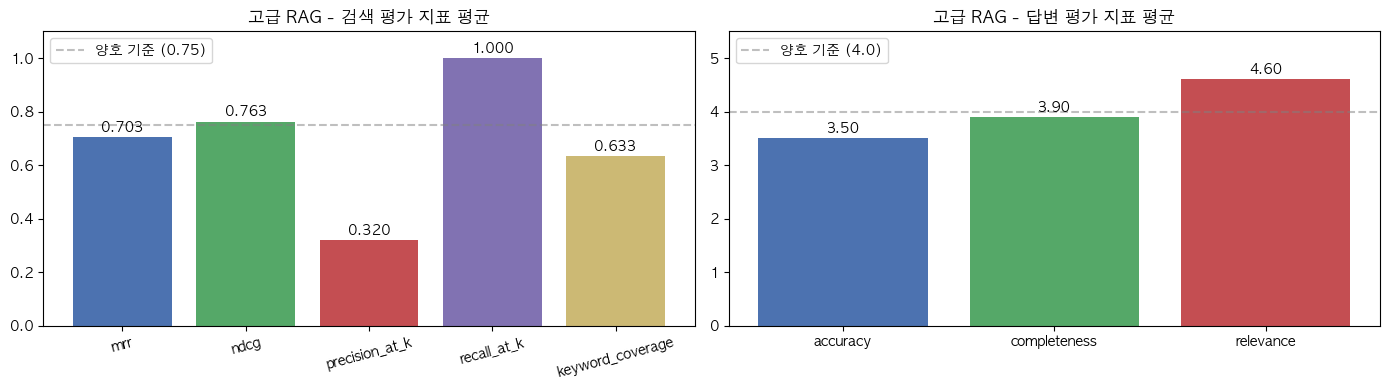

In [138]:
import pandas as pd

# 결과를 DataFrame으로 변환
df = pd.DataFrame(results)

# 전체 평균
metrics = ["mrr", "ndcg", "precision_at_k", "recall_at_k", "keyword_coverage", "accuracy", "completeness", "relevance"]
available_metrics = [m for m in metrics if m in df.columns]
avgs = df[available_metrics].mean()

print("[고급 RAG 전체 평균]")
for m in available_metrics:
    if m in ("accuracy", "completeness", "relevance"):
        print(f"  {m:20s}: {avgs[m]:.2f}/5")
    else:
        print(f"  {m:20s}: {avgs[m]:.4f}")

# 바 차트
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 검색 지표
retrieval_metrics = [m for m in ["mrr", "ndcg", "precision_at_k", "recall_at_k", "keyword_coverage"] if m in avgs.index]
bar_colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974"]
axes[0].bar(retrieval_metrics, [avgs[m] for m in retrieval_metrics], color=bar_colors[:len(retrieval_metrics)])
axes[0].set_ylim(0, 1.1)
axes[0].set_title("고급 RAG - 검색 평가 지표 평균")
axes[0].axhline(y=0.75, color="gray", linestyle="--", alpha=0.5, label="양호 기준 (0.75)")
axes[0].legend()
axes[0].tick_params(axis='x', rotation=15)
for i, m in enumerate(retrieval_metrics):
    axes[0].text(i, avgs[m] + 0.02, f"{avgs[m]:.3f}", ha="center")

# 답변 지표
answer_metrics = [m for m in ["accuracy", "completeness", "relevance"] if m in avgs.index]
if answer_metrics:
    axes[1].bar(answer_metrics, [avgs[m] for m in answer_metrics], color=["#4C72B0", "#55A868", "#C44E52"])
    axes[1].set_ylim(0, 5.5)
    axes[1].set_title("고급 RAG - 답변 평가 지표 평균")
    axes[1].axhline(y=4.0, color="gray", linestyle="--", alpha=0.5, label="양호 기준 (4.0)")
    axes[1].legend()
    for i, m in enumerate(answer_metrics):
        axes[1].text(i, avgs[m] + 0.1, f"{avgs[m]:.2f}", ha="center")

plt.tight_layout()
plt.show()

[카테고리별 평균 점수]

  direct_fact:
    MRR=0.703  nDCG=0.763  P@K=0.320  R@K=1.000  Coverage=63.3%  Acc=3.5  Comp=3.9  Rel=4.6


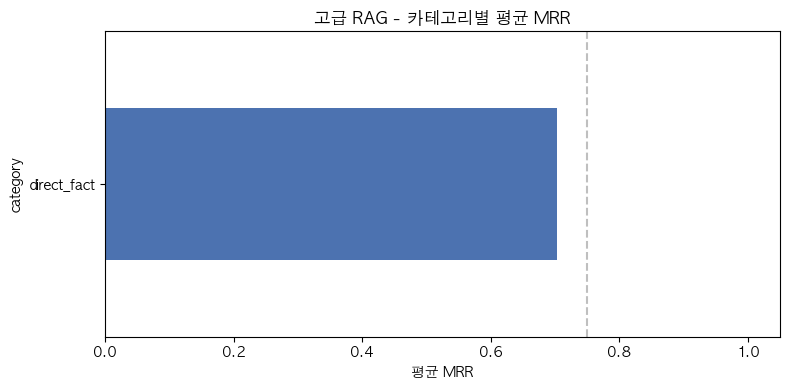

In [139]:
# 카테고리별 분석
print("[카테고리별 평균 점수]\n")

cat_group = df.groupby("category")[available_metrics].mean()

for cat in cat_group.index:
    row = cat_group.loc[cat]
    print(f"  {cat}:")
    print(f"    MRR={row['mrr']:.3f}  nDCG={row['ndcg']:.3f}  P@K={row['precision_at_k']:.3f}  R@K={row['recall_at_k']:.3f}  Coverage={row['keyword_coverage']:.1%}", end="")
    if "accuracy" in row.index:
        print(f"  Acc={row['accuracy']:.1f}  Comp={row['completeness']:.1f}  Rel={row['relevance']:.1f}")
    else:
        print()

# 카테고리별 MRR 바 차트
fig, ax = plt.subplots(figsize=(8, 4))
cat_mrr = df.groupby("category")["mrr"].mean().sort_values(ascending=True)
cat_mrr.plot.barh(ax=ax, color="#4C72B0")
ax.set_xlabel("평균 MRR")
ax.set_title("고급 RAG - 카테고리별 평균 MRR")
ax.axvline(x=0.75, color="gray", linestyle="--", alpha=0.5)
ax.set_xlim(0, 1.05)
plt.tight_layout()
plt.show()

## 정리

이번 노트북에서 학습한 고급 RAG 기법들:

### 1. LLM 기반 지능형 청킹
- 고정 크기 분할 대신 LLM이 의미 단위로 분할
- headline + summary + original_text 구조로 검색 품질 향상
- Pydantic을 활용한 Structured Output

### 2. Reranking (재순위화)
- 벡터 유사도 검색 후 LLM이 재정렬
- 의미적 관련성 기반 순위 부여
- 검색 정확도 향상 (MRR, nDCG 개선)

### 3. Query Rewriting (쿼리 재작성)
- 사용자 질문을 검색 최적화 형태로 변환
- 대화 맥락 고려
- 검색 정확도 향상

### 4. 07-1과 동일한 평가 프레임워크로 비교
- 동일한 Knowledge Base (`00_test_data/knowledge_base`)와 테스트 데이터 (`tests.jsonl`) 사용
- 동일한 평가 지표 (MRR, nDCG, Precision@K, Recall@K, LLM-as-a-Judge)
- 기본 RAG 대비 고급 RAG의 성능 차이를 정량적으로 확인

### 다음 단계
- HyDE (Hypothetical Document Embeddings)
- Multi-query RAG
- RAG Fusion
- Self-RAG